In [1]:

import numpy as np 
import pandas as pd 
import os
import imageio
from PIL import Image
import tifffile
# !pip install imagecodecs
import imagecodecs
import cv2
import matplotlib.pyplot as plt
from numpy import asarray
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

## Data: Loading and pre-processing 

Dataset info: 
1. /train/ contains the training set images, named according to subject_imageNum.tif. Every image with the same subject number comes from the same person. This folder also includes binary mask images showing the BP segmentations.
2. /test/ contains the test set images, named according to imageNum.tif. You must predict the BP segmentation for these images and are not provided a subject number. There is no overlap between the subjects in the training and test sets.
3. train_masks.csv gives the training image masks in run-length encoded format. This is provided as a convenience to demonstrate how to turn image masks into encoded text values for submission 



In [3]:
def LoadData (path):
    """
    Loads image dataset from the given path and returns two lists:
    - original: a list of filenames of the original images
    - mask: a list of filenames of the corresponding mask images
    
    Arguments:
    path -- the directory path where the images are stored
    
    Returns:
    original -- a list of filenames of the original images
    mask -- a list of filenames of the corresponding mask images
    """
    dataset = os.listdir(path)
    original = []
    mask = []
    dataset.sort()
    for file in dataset:
        if file.endswith('_mask.tif'):
            mask.append(file)
            original.append(file.replace("_mask.tif",".tif"))       
    return original, mask

(420, 580)
(420, 580)


Text(0.5, 1.0, 'Masked Image 10_82_mask.tif')

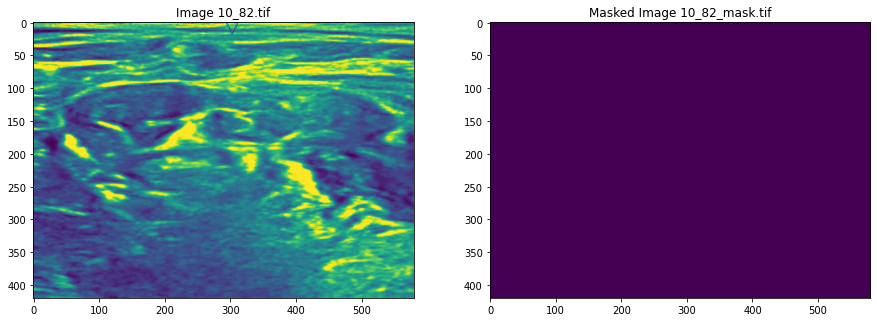

In [6]:
# Set the directory path and load the data
path = '../input/ultrasound-nerve-segmentation/train/'
img, mask = LoadData (path)
# Set the index of the image to display
show = 100

# Load the image and mask
img_view  = imageio.imread(path + img[show])
mask_view = imageio.imread(path + mask[show])

# Display the image and mask side by side
print(img_view.shape)
print(mask_view.shape)
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[0].set_title('Image ' + img[show])
arr[1].imshow(mask_view)
arr[1].set_title('Masked Image '+ mask[show])

In [7]:
def PreprocessData(img, mask, targetshape, targetshape_mask, path, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel

    This function takes in a list of image filenames img, a 
    corresponding list of mask filenames mask, the desired shape of the images targetshape, 
    the desired shape of the masks targetshape_mask, the directory path where the images are stored path, 
    and the directory path where the masks are stored path2. It processes the images and masks using the PIL and cv2 modules and 
    returns a NumPy dataset with images as 3-D arrays of the desired size and masks as 3-D arrays of size (m, m_h, m_w, m_c), 
    where m is the number of images, m_h is the height of the mask, m_w is the width of the mask, and m_c is the number of channels 
    in the mask (which is 1 in this case). The images and masks are scaled to the range [0,1] and returned as float32 and int32 NumPy arrays, respectively.

    """
    m = len(img)                     
    i_h,i_w,i_c = targetshape   
    m_h,m_w,m_c = targetshape_mask  

    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    for file in img:
        index = img.index(file)
        path = os.path.join(path, file)
        simg = Image.open(path).convert('RGB')
        simg = simg.resize((i_h,i_w))
        simg = np.reshape(simg,(i_h,i_w,i_c)) 
        simg = simg/256.
        X[index] = simg
                
        single_mask_ind = mask[index]
        path = os.path.join(path, single_mask_ind)
        smask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        smask = cv2.resize(smask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        smask = asarray(smask)
        smask = smask[..., tf.newaxis]
        smask = np.reshape(smask,(m_h,m_w,m_c)) 
        smask = smask/255
        smask = smask.astype(int) 
        y[index] = smask
    return X, y

X Shape: (5635, 128, 128, 3)
Y shape: (5635, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

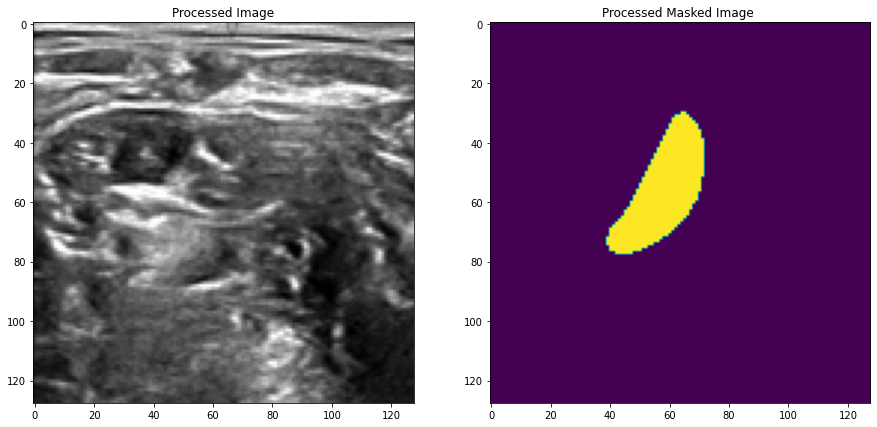

In [8]:
targetshape = [128, 128, 3]
targetshape_mask = [128, 128, 1]

X, y = PreprocessData(img, mask, targetshape, targetshape_mask, path, path)

print("X Shape:", X.shape)
print("Y shape:", y.shape)
print(np.unique(y))

index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 2. Building Unet

In [9]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, and ReLU activation to create a deep learning architecture. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for the next layer along with a skip connection which will be used in the decoder.
    
    Arguments:
    inputs -- the input tensor or image
    n_filters -- the number of filters in the convolutional layers (default is 32)
    dropout_prob -- the probability of dropout regularization (default is 0.3)
    max_pooling -- whether to use max pooling or not (default is True)
    
    Returns:
    next_layer -- the activation values for the next layer
    skip_connection -- the skip connection tensor for the corresponding decoder layer
    """
    
    # Add 2 Conv layers with ReLU activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to the convolutional layer such that the output has the same height and width 
    # (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 3, activation=ReLU(), padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation=ReLU(), padding='same', kernel_initializer='he_normal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels the same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)    
    else:
        next_layer = conv

    # The skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection


In [10]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    The Decoder Block first uses a transpose convolution to upscale the image to a larger size and then
    merges the result with skip layer results from the Encoder Block.
    Adding 2 Conv layers with 'same' padding helps further increase the depth of the network for better predictions.
    The function returns the decoded layer output.
    
    Arguments:
    prev_layer_input -- the input tensor or image for the previous layer
    skip_layer_input -- the input tensor or image for the corresponding Encoder Block's skip connection
    n_filters -- the number of filters in the convolutional layers (default is 32)
    
    Returns:
    conv -- the output tensor or image of the decoded layer
    """
    
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(prev_layer_input)

    # Merge the skip connection from the previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv layers with ReLU activation and HeNormal initialization for further processing
    # The parameters for the function are similar to those of the Encoder Block
    conv = Conv2D(n_filters, 3, activation=ReLU(), padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation=ReLU(), padding='same', kernel_initializer='he_normal')(conv)
    
    return conv


In [11]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    """
    The U-Net model is a type of convolutional neural network that is commonly used for image segmentation tasks.
    This function compiles a U-Net model that consists of an Encoder and Decoder blocks.
    
    Arguments:
    input_size -- the input size of the image (default is (128, 128, 3))
    n_filters -- the number of filters in the convolutional layers (default is 32)
    n_classes -- the number of output classes (default is 2)
    
    Returns:
    model -- the compiled U-Net model
    """

    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different max pooling, dropout, and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increase the number of channels in the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the Encoder are given as input to the Decoder
    # Recall the 2nd output of the Encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1], n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1], n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1], n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the previous Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe that the number of channels will be equal to the number of output classes
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [12]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=2)

unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:

unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

results = unet.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
141/141 [==============================] - 45s 214ms/step - loss: 0.0856 - accuracy: 0.9727 - val_loss: 0.0388 - val_accuracy: 0.9876
Epoch 2/30
141/141 [==============================] - 25s 181ms/step - loss: 0.0316 - accuracy: 0.9880 - val_loss: 0.0289 - val_accuracy: 0.9876
Epoch 3/30
141/141 [==============================] - 27s 191ms/step - loss: 0.0275 - accuracy: 0.9880 - val_loss: 0.0286 - val_accuracy: 0.9876
Epoch 4/30
141/141 [==============================] - 27s 191ms/step - loss: 0.0254 - accuracy: 0.9881 - val_loss: 0.0258 - val_accuracy: 0.9880
Epoch 5/30
141/141 [==============================] - 26s 188ms/step - loss: 0.0238 - accuracy: 0.9905 - val_loss: 0.0248 - val_accuracy: 0.9900
Epoch 6/30
141/141 [==============================] - 26s 187ms/step - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0245 - val_accuracy: 0.9902
Epoch 7/30
141/141 [==============================] - 27s 189ms/step - loss: 0.0212 - accuracy: 0.9917 - val_loss: 0.0229 - val_ac

## 3. Predictions

In [14]:
path2 = '../input/ultrasound-nerve-segmentation/test/'
dataset = os.listdir(path2)
test_img = []
for file in dataset:
    test_img.append(file)

In [18]:

m = len(test_img)                     
i_h,i_w,i_c = targetshape   

test_X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)

for file in test_img:
    index = test_img.index(file)
    path = os.path.join(path2, file)
    simg = Image.open(path).convert('RGB')
    simg = simg.resize((i_h,i_w))
    simg = np.reshape(simg,(i_h,i_w,i_c)) 
    simg = simg/256.
    test_X[index] = simg
    

test_y = []
for img in test_X:
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    test_y.append(pred_mask)

In [15]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] 
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [19]:
import pandas as pd
test_output = pd.DataFrame(columns = ['img','pixels'])

for i,item in enumerate(test_y):
    encoding = rle_encoding(item.numpy())
    pixels = ' '.join(map(str, encoding))
    df = {'img': test_img[i][:-4], 'pixels': pixels}
    test_output = test_output.append(df, ignore_index = True)

test_output

,img,pixels
0,1259,
1,659,6834 7 6959 12 7085 14 7212 15 7334 21 7461 22...
2,4794,
3,274,8103 3 8219 16 8345 20 8473 22 8600 24 8727 25...
4,315,
...,...,...
5503,474,
5504,4056,6707 10 6822 26 6947 30 7074 31 7201 32 7329 3...
5505,3842,8742 14 8866 21 8991 28 9117 32 9245 34 9373 3...
5506,2681,
